<a href="https://colab.research.google.com/github/comrademaggie/requests/blob/master/Santander_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Background 

This dataset is from the [Santander Kaggle competition](https://www.kaggle.com/c/santander-customer-transaction-prediction).  There are 200 numeric variables and a binary target variable to represent whether a transaction happened or not.  The goal of the competition is to try to predict customers that will transact, irrespective of the transaction amount.  The competition is evaluated on area under the ROC curve between the predicted probability and the observed target.

The dataset is anonymized and no additional information is provided regarding the features. We are also provided with an imbalanced target outcome, so this competition provides an opportunity to explore resampling techniques.  

##Outline

1. Initial data exploration
2. Base case models on the unbalanced dataset
3. Undersampling 
4. Oversampling
5. SMOTE sampling
6. Submission and Conclusion

---



In [0]:
#@title
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"comrademaggie","key":"c9ebec6980199dd0ba6bcd2f10870962"}'}

In [0]:
#@title
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 700 ~/.kaggle/kaggle.json
!kaggle competitions download -c santander-customer-transaction-prediction

 90% 110M/122M [00:01<00:00, 89.1MB/s] 
100% 122M/122M [00:01<00:00, 101MB/s] 
  0% 0.00/463k [00:00<?, ?B/s]
100% 463k/463k [00:00<00:00, 53.8MB/s]
 86% 105M/122M [00:00<00:00, 99.1MB/s] 
100% 122M/122M [00:00<00:00, 132MB/s] 


In [0]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score


In [0]:
train = pd.read_csv('../content/train.csv.zip')


##1. Initial Data Exploration

Summary:


*   There are 200,000 entries, or total customers, in the train dataset
*   There are 20,000 target transactions, or roughly 10% of total customers
*   There are no missing values, but there are high number of unique values per variable.
*   None of the features are correlated. 
*   Taking a quick glance at a random 25% subsample of the dataset, all of the features look normally distributed with no detectable differences between the transactors and non-transactors. 



The data is unbalanced in terms of target values 1, which will skew the model.   When we have a dominant class of 90% non-transactors, the model can perform well by just predicting the most likely outcome.  

Though we don't have much information on whether these are good transactions (those reacting to advertising?) or bad (fraud?), we do know that the competition wants us to correctly identify the minority class, or the transactors.  This is why we will next take several sampling approaches to try to deal with this imbalance before training the model. 

Total Customers:  200000
Total Target Transactions:  20098
Percentage of Trx :  10.049


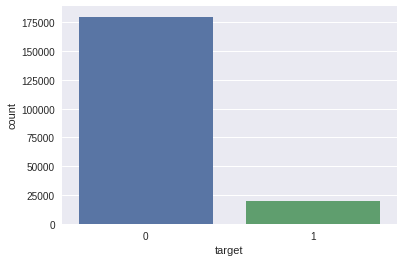

In [0]:
#@title
#data count and countplot

Trx = train.target.sum()
Total = train.ID_code.count()
print('Total Customers: ', Total)
print('Total Target Transactions: ', Trx)
print('Percentage of Trx : ', Trx/Total*100)
sns.countplot(x="target", data=train)

In [0]:
#@title
#feature summary
column_summ = []
for col in train.columns:
    column_summ.append((col, train[col].count(), train[col].nunique(), train[col].isnull().sum(), train[col].dtype))

    
column_summary_df = pd.DataFrame(data=column_summ, columns=['Feature', 'Count', 'Unique_val_count', 'Nan_count', 
                                                             'Type'])

    
column_summary_df.sort_values('Nan_count', ascending = False)

In [0]:
#@title
#correlation matrix 
corrtrain = train.corr(method="pearson")
sns.heatmap(corrtrain, vmax=1, square=True)

<Figure size 432x288 with 0 Axes>

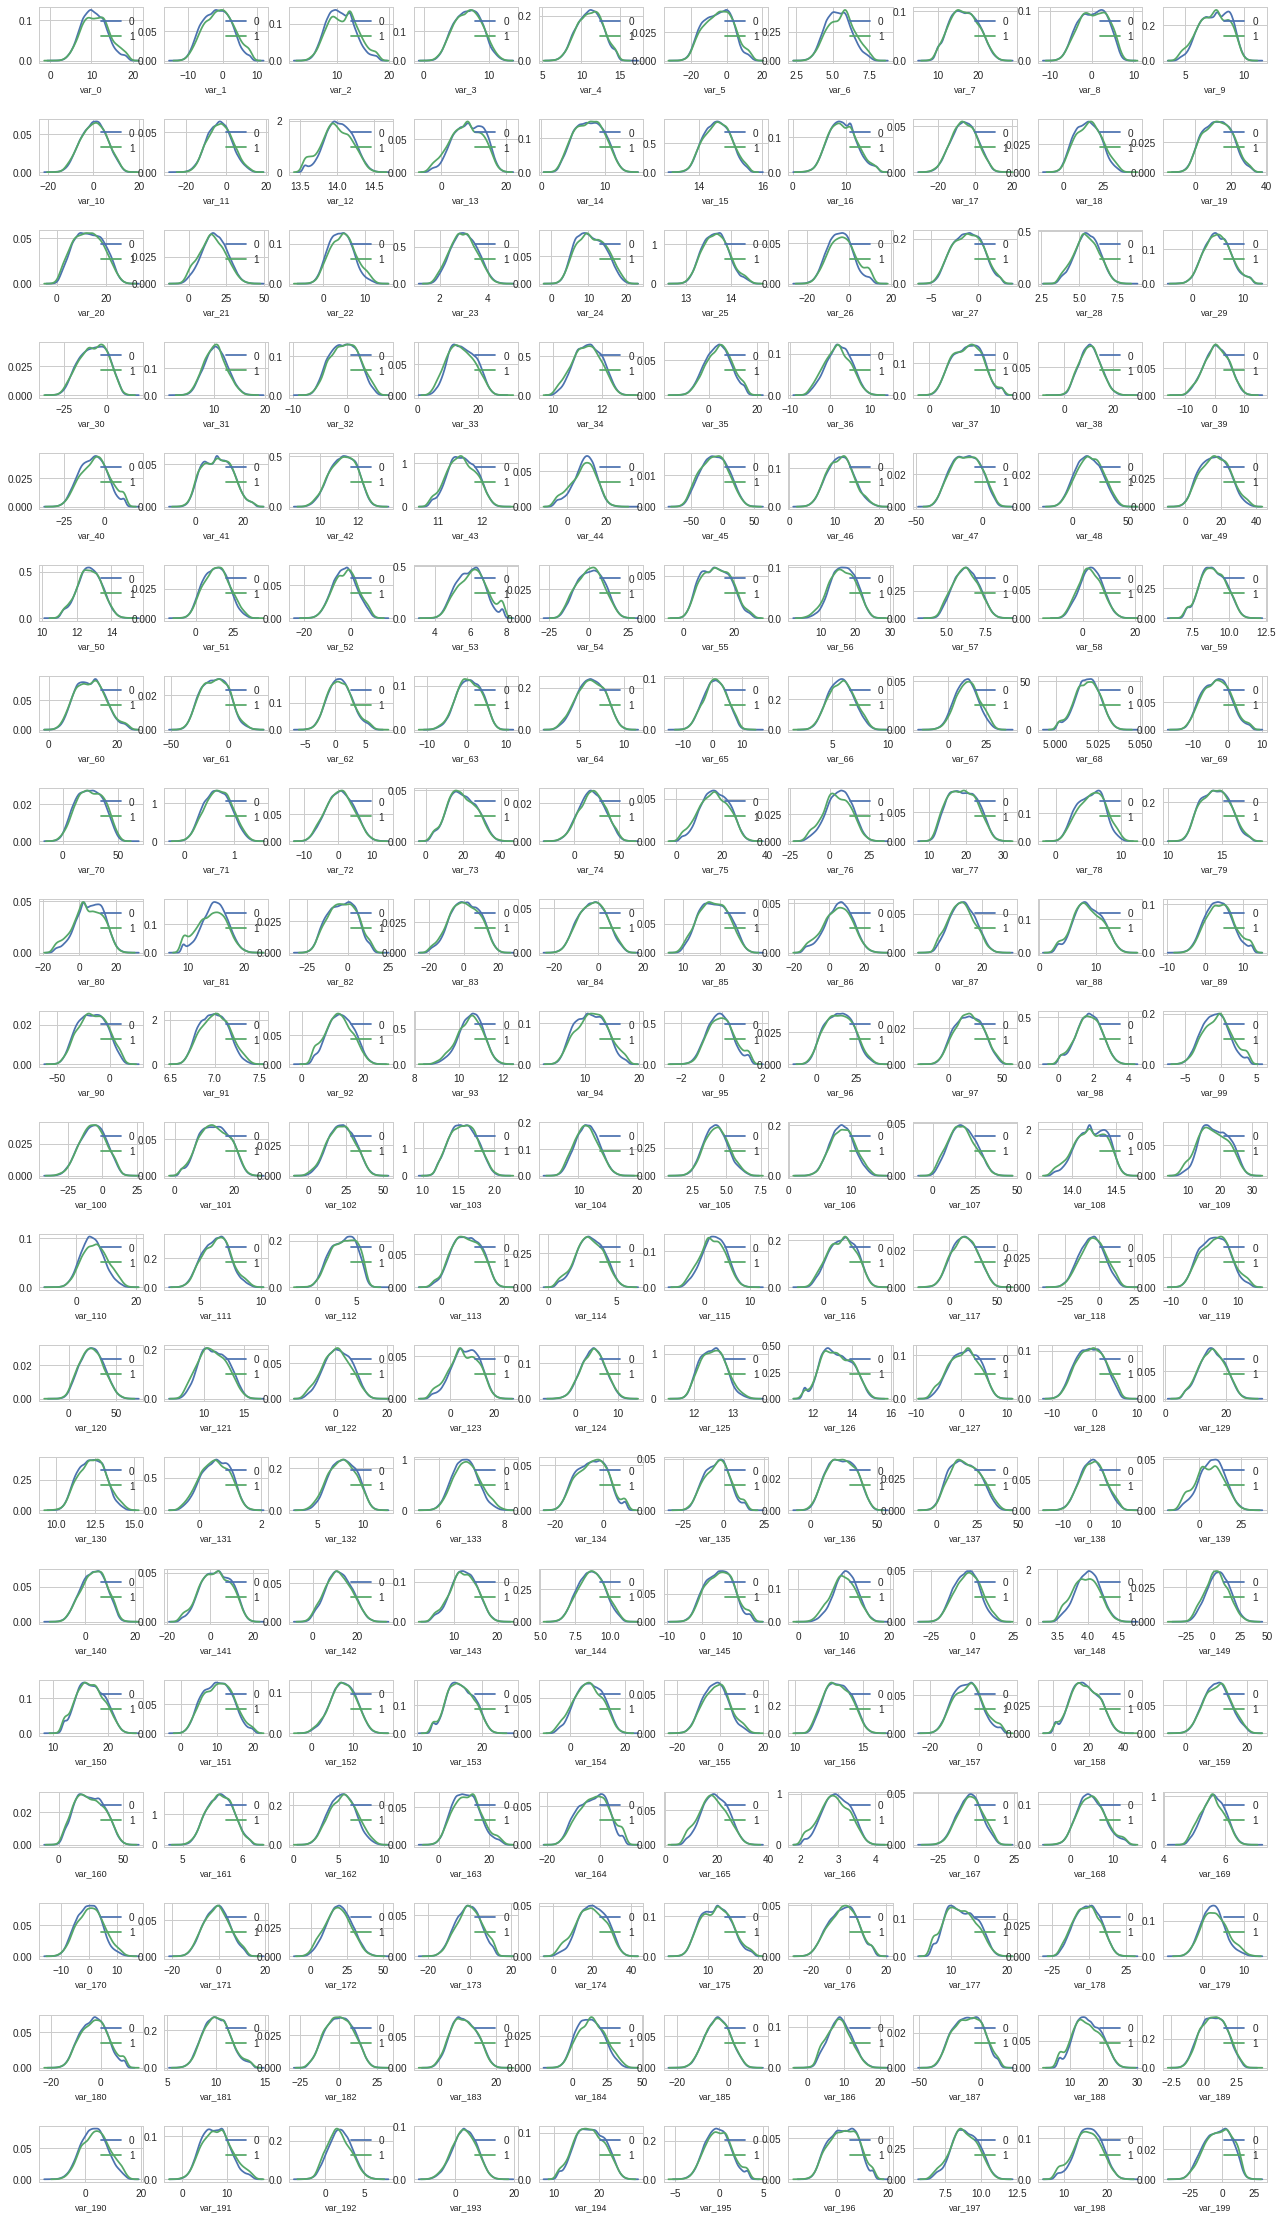

In [0]:
#@title
#get random 25% sample of train set 
sample = train.sample(frac=0.25, replace=False)

#set sample target = 1 and 0 for graphing 
samp0 = sample.loc[sample['target'] == 0]
samp1 = sample.loc[sample['target'] == 1]
features = sample.columns.values[2:]

#plot all 200 features
i = 0
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(20,10,figsize=(22,40))

for feature in features:
  i +=1
  plt.subplot(20,10,i)
  sns.kdeplot(samp0[feature], label=0)
  sns.kdeplot(samp1[feature], label=1)
  plt.xlabel(feature, fontsize=9)
  plt.legend(loc=1)

plt.subplots_adjust(hspace=1, wspace=0.2)
plt.show()

##2. Base case models on the unbalanced dataset

## a. Gaussian Naive Bayes (GNB)
**Rationale for Use:**  Gaussian Naive Bayes assumes that all features are normally distributed.  It is also a simple and useful classifier model to use where the outcome is binary.  In our base case GNB model, the data imbalance has not been treated.

**Results:** The ROC scores between test and train sets show us that the model is underfitting. The confusion matrix also tells us that the model is not identifying transactors very well, with a very low recall score.  This tells us that the data imbalance is indeed impacting the model. 

In [0]:
#@title
#set X and Y equal to the features and target respectively
Y = train['target']
X = train.iloc[:, 2:]

#scale the X variables
scaler = StandardScaler()
scaler.fit(X)
X_Scaled = scaler.transform(X)

# Instantiate our model and store it in a new variable.
gnb = GaussianNB()

# Use train_test_split to create the necessary training and test group of 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X_Scaled, Y, test_size=0.2)

#fit the model and set it as model1
model1 = gnb.fit(X_train, y_train)

#get accuracy from model
cross_val_pred = cross_val_predict(model1, X_train, y_train, cv=5)
y_test_pred = model1.predict(X_test)
y_test_pred_prob = model1.predict_proba(X_test)[:,1]

print('ROC Train: ', roc_auc_score(y_train, cross_val_pred))
print('ROC Test: ', roc_auc_score(y_test, y_test_pred_prob))
print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_test_pred))



ROC Train:  0.6714501874886227
ROC Test:  0.8911187074164066
Test Confusion Matrix: 
 [[35432   587]
 [ 2491  1490]]


##b. Logistic Regression
**Rationale for Use:** Logistic regression is another "basic" classifier that has a class weights parameter that can be set to "balanced".  This will automatically adjust weights inversely proportional to class outcomes, thereby coping with the class imbalance. GridSearchCV can be used to find the best regularization parameter (C=.001).  

**Results:** The difference between test and train ROC scores has improved, and there is an improvement in identifying transactors.  However, the confusion matrix tells us there is now an issue with false positives, and the model is finding too many transactors.  



In [0]:
#@title
#using GridSearchCV to find the best regularization parameter
lr_balance = LogisticRegression(penalty = 'l2', class_weight='balanced')
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
clf_balance = GridSearchCV(lr_balance, parameters, scoring='roc_auc', cv = 5)
clf_balance.fit(X_train, y_train)


print(clf_balance.best_score_)
print(clf_balance.best_params_)

0.8586720075966212
{'C': 0.001}


In [0]:
#@title
lr_balance_best = LogisticRegression(penalty='l2', class_weight='balanced', C=.001)
lr_balance_best.fit(X_train, y_train)

cross_val_pred = cross_val_predict(lr_balance_best, X_train, y_train, cv=5)
y_test_pred_prob = lr_balance_best.predict_proba(X_test)[:,1]
y_test_pred = lr_balance_best.predict(X_test)

print('Train ROC: ', roc_auc_score(y_train, cross_val_pred))
print('Test ROC: ', roc_auc_score(y_test, y_test_pred_prob))
print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_test_pred))

Train ROC:  0.777240987807573
Test ROC:  0.8607975805493716
Test Confusion Matrix: 
 [[27826  8129]
 [  853  3192]]


##c. Light Gradient Boosting Machine
**Rationale for use:** LGB is a tree-based algorithm that builds vertically, or leaf-wise, instead of horizontally, or level-wise, as in Random Forest classifier.  It is a highly performant and computationally efficient model, hence "light", and could thus be useful in this context.  As it is prone to overfitting, it is not suitable for datasets with less than 10k rows.  X_train has 160,000 rows.   We set the objective to binary classification and use the traditional gradient boosting decision tree (gbdt).  

Notes on the parameters: 

<br>To deal with overfitting: 
* lower max_depth (7) and num_leaves as less than 2^max_depth (70)
* raise min_data_in_leaf (100, default is 20)

<br>For speed:
* use bagging_fraction and feature_fraction as less than 1
* use a learning_rate > .005 


<br>**Results:**
The ROC score improves to 89.7%!   The confusion matrix tells us it is not as good at identifying transactors, with most of its errors in false negatives.  We will see if sampling techniques can improve upon this model. 

In [0]:
#@title
#prepare train and test datasets for model
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

#set parameters
params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['bagging_fraction'] = 0.8
params['bagging_freq']=10
params['feature_fraction']=0.8
params['metric'] = 'auc'
params['num_leaves'] = 70
params['max_depth'] = 7
params['min_data_in_leaf'] = 100

#fit the model
clf = lgb.train(params, d_train, 10000, valid_sets = [d_train, d_test], early_stopping_rounds = 50, verbose_eval=1000)



Training until validation scores don't improve for 50 rounds.
[1000]	training's auc: 0.961096	valid_1's auc: 0.880606
[2000]	training's auc: 0.984535	valid_1's auc: 0.892494
[3000]	training's auc: 0.993412	valid_1's auc: 0.896856
Early stopping, best iteration is:
[3341]	training's auc: 0.99508	valid_1's auc: 0.897413


In [0]:
#@title
y_test_pred_prob=clf.predict(X_test)
y_test_pred = np.where(y_test_pred_prob>=0.5, 1, 0)
print('Test Confusion Matrix: \n', confusion_matrix(y_test, y_test_pred))

Test Confusion Matrix: 
 [[35789   230]
 [ 2856  1125]]


##3. Undersampling

The first technique we use to cope with the class imbalance is random undersampling.  We randomly eliminate the majority class, or non-transactors, in this case, until there is a 50%-50% split in the binary class outcome.  

**Other comments:**



1.   There is still no correlation between features in the undersampled set, thus we still don't see any particular features heavily influencing the outcome

2.   One mistake I made before was in applying the train-test-split *after* undersampling instead of *before*.  We should leave the test set untouched and unaffected by undersampling because we want to score the model on an untouched sample.  This would give us a better indication of how our model is truly performing.  Sampling before splitting would also allow the same data to be in both test and train sets, and the model may just memorize data points, leading to overfitting. 
3. Undersampling reduces our train dataset size from 160k rows to just 32k, which makes any modeling prone to overfitting.  With under 100k samples, we can use more simple and faster classification models and don't need to apply techniques like gradient boosting, which would be subject to overfitting.  



In [0]:
#@title
#split the dataset into train/test first
train_80, test_20 = train_test_split(train, test_size=0.2)

#split the target outcomes into separate datasets
train_80_target_1 = train_80.loc[train_80['target'] == 1]
train_80_target_0 = train_80.loc[train_80['target'] == 0]

#randomly sample target=0 such that it equals the length of target=1
train_80_target_0_samp = train_80_target_0.sample(n=len(train_80_target_1), random_state=12)
train_undersample = train_80_target_1.append(train_80_target_0_samp)



Total Customers:  32002
Total Target Transactions:  16001
Percentage of Trx :  50.0


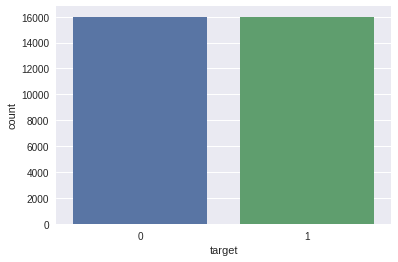

In [0]:
#@title
#verify new undersample class balance

Trx_us = train_undersample.target.sum()
Total_us = train_undersample.ID_code.count()
print('Total Customers: ', Total_us)
print('Total Target Transactions: ', Trx_us)
print('Percentage of Trx : ', Trx_us/Total_us*100)

sns.countplot(x='target', data=train_undersample)

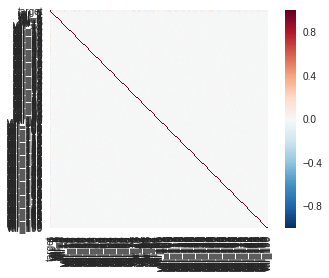

In [0]:
#@title
undersample_corr = train_undersample.corr(method="pearson")
sns.heatmap(undersample_corr, vmax=1, square=True)

##a. Modeling
I apply four "out-of-the-box " classifers to my undersample: 

 *   Gaussian Naive Bayes
 *   Bernoulli Naive Bayes
 *   Logistic Regression
 *   Random Forest





**Results:** 
With all four models, the test set outperforms the train set, a result that usually doesn't happen.  I use cross validation with training, which produces the more reliable, though lower, score.  The models are sensitive to the undersampling technique, and are now over-predicting transactors in the test set.  The best performing of the lot is the Gaussian Naive Bayes model, but it does not outperform the LGB model from above.  

In [0]:
#@title
#set X and Y equal to the features and target respectively
X_us = train_undersample.iloc[:, 2:]
Y_us = train_undersample.target


#scale the X variables
scaler = StandardScaler()
scaler.fit(X_us)
X_us_scaled = scaler.transform(X_us)



In [0]:
#@title
#scale X_test and Y_test, which have not been touched in the undersampling exercise

X_test = test_20.iloc[:, 2:]
Y_test = test_20.target

#scale the X variables
scaler.fit(X_test)
X_test = scaler.transform(X_test)


In [0]:
#@title
#Instantiate different classifiers
gnb = GaussianNB()
bnb = BernoulliNB()
lr = LogisticRegression(C=.001)
rfc = ensemble.RandomForestClassifier()

classifiers = [gnb, bnb, lr, rfc]

<Figure size 432x288 with 0 Axes>

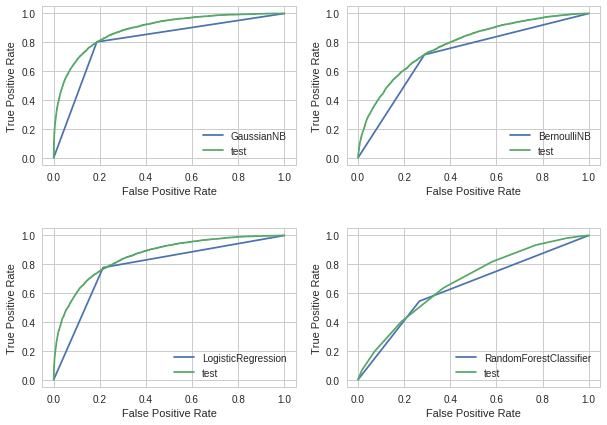

,Classifier,Test ROC,Train ROC
0,"GaussianNB(priors=None, var_smoothing=1e-09)",0.888303,0.807937
1,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri...",0.782819,0.713137
2,"LogisticRegression(C=0.001, class_weight=None,...",0.858907,0.781688
3,"(DecisionTreeClassifier(class_weight=None, cri...",0.679336,0.639130


In [0]:
#@title
train_roc = []
test_roc = []
i = 0
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(10,7))


for classifier in classifiers:
  classifier.fit(X_us_scaled, Y_us)
  y_test_pred = classifier.predict(X_test)
  y_test_pred_prob = classifier.predict_proba(X_test)[:,1]
  cross_val_pred = cross_val_predict(classifier, X_us_scaled, Y_us, cv=5)
  train_roc.append(roc_auc_score(Y_us, cross_val_pred))
  test_roc.append(roc_auc_score(Y_test, y_test_pred_prob))
  fpr, tpr, threshold = roc_curve(Y_us, cross_val_pred)
  fpr_test, tpr_test, threshold_test = roc_curve(Y_test, y_test_pred_prob)
  i +=1
  plt.subplot(2,2,i)
  plt.plot(fpr, tpr, label=str(classifier).split('(',1)[0])
  plt.plot(fpr_test, tpr_test, label='test')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc='lower right')
  

plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.show()

df_scores = pd.DataFrame({'Classifier': classifiers, 'Train ROC': train_roc, 'Test ROC': test_roc})
df_scores

##b. Light Gradient Boosting Machine on the undersample
Keeping in mind that the dataset has been sharply reduced with our undersampling technique, we will adjust the parameters to cope with potential overfitting.    
<br>To deal with overfitting: 
* leave min_data_in_leaf as default 20

<br>For speed:
* use bagging_fraction and feature_fraction as less than 1

<br>For better accuracy: 
* use an even smaller learning_rate (.003 from .01) with larger num_iterations (20k)

<br>**Results:**
The ROC score is quite good on the test set at 88.4%, but not as good as the 89.7% we achieved on the imbalanced dataset.  The confusion matrix tells us we have certainly improved at identifying transactors - but almost *too* well.  We now have a high percentage of false positives, and our precision is not as high.  This tells us that undersampling so that the outcomes are evenly weighted is actually skewing the LGB model. 

In [0]:
#@title
#prepare train and test datasets for model
us_train = lgb.Dataset(X_us_scaled, label=Y_us)
us_test = lgb.Dataset(X_test, label=Y_test)

#set parameters
params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['bagging_fraction'] = 0.8
params['bagging_freq']=10
params['feature_fraction']=0.8
params['metric'] = 'auc'
params['num_leaves'] = 70
params['max_depth'] = 7
params['min_data_in_leaf'] = 20

#fit the model
clf = lgb.train(params, us_train, 20000, valid_sets = [us_test], early_stopping_rounds = 50, verbose_eval=1000)



Training until validation scores don't improve for 50 rounds.
[1000]	valid_0's auc: 0.826132
[2000]	valid_0's auc: 0.853127
[3000]	valid_0's auc: 0.865081
[4000]	valid_0's auc: 0.872225
[5000]	valid_0's auc: 0.876347
[6000]	valid_0's auc: 0.879173
[7000]	valid_0's auc: 0.881268
[8000]	valid_0's auc: 0.882903
[9000]	valid_0's auc: 0.884016
Early stopping, best iteration is:
[9162]	valid_0's auc: 0.884216


In [0]:
#@title
y_test_pred_prob=clf.predict(X_test)
y_test_pred = np.where(y_test_pred_prob>=0.5, 1, 0)
print('Test Confusion Matrix: \n', confusion_matrix(Y_test, y_test_pred))

Test Confusion Matrix: 
 [[21629 14355]
 [  330  3686]]


##4. Oversampling
The second sampling technique we will use is oversampling, where we will overweight the transactors dataset 8 times over so that we achieve a 50%-50% binary class balance. This does increase our data count from 200k in the original set to 288k , which is a plus, since more data is always better for modeling.  There is also no information loss.  However, the data from the minority class is replicated 8 times over, and thus the modeling could still be prone to overfitting.  

In [0]:
#@title
#create the oversample
train_80_target_1_times9 = pd.concat([train_80_target_1]*9, ignore_index=True)
train_oversample = train_80_target_0.append(train_80_target_1_times9)

Total Customers:  288656
Total Target Transactions:  144738
Percentage of Trx :  50.142037581065345


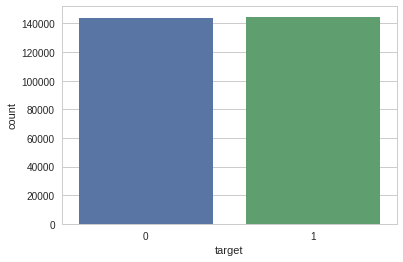

In [0]:
#@title
Trx_os = train_oversample.target.sum()
Total_os = train_oversample.ID_code.count()
print('Total Customers: ', Total_os)
print('Total Target Transactions: ', Trx_os)
print('Percentage of Trx : ', Trx_os/Total_os*100)
sns.countplot(x='target', data=train_oversample)

In [0]:
#@title
#set X and Y equal to the features and target respectively
X_os = train_oversample.iloc[:, 2:]
Y_os = train_oversample.target

#scale the X variables
scaler.fit(X_os)
X_os_scaled = scaler.transform(X_os)



##a. Modeling 
I apply three "out-of-the-box " classifers to my oversample:

* Gaussian Naive Bayes
* Bernoulli Naive Bayes
* Logistic Regression

I decided to drop the Random Forest classifier as it is more computationally intensive with an enlargened dataset, but will revisit it separately later. 

**Results:**  Gaussian Naive Bayes performs the best of the three, and the train-test scores have improved from the base case, while the difference between train and test scores has also narrowed.  While oversampling has improved our base models, the results are still not as impressive as the 89% score from the LGB model we ran on the original dataset.  

In [0]:
#@title
#Instantiate different classifiers
gnb = GaussianNB()
bnb = BernoulliNB()
lr = LogisticRegression(C=.001)

classifiers = [gnb, bnb, lr]


<Figure size 432x288 with 0 Axes>

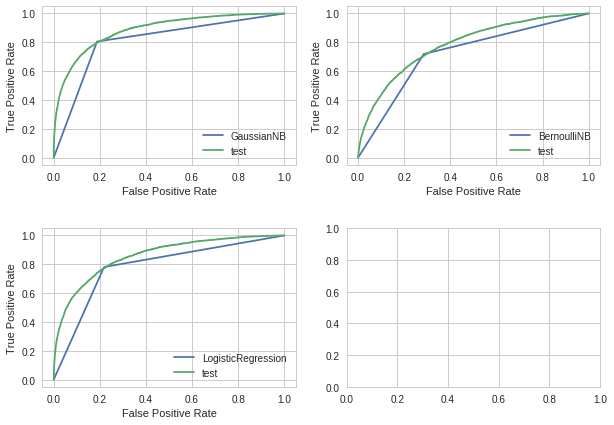

,Classifier,Test ROC,Train ROC
0,"GaussianNB(priors=None, var_smoothing=1e-09)",0.884875,0.808827
1,"BernoulliNB(alpha=1.0, binarize=0.0, class_pri...",0.782843,0.716976
2,"LogisticRegression(C=0.001, class_weight=None,...",0.857849,0.781432


In [0]:
#@title
train_roc = []
test_roc = []
i = 0
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(10,7))


for classifier in classifiers:
  classifier.fit(X_os_scaled, Y_os)
  training_score = cross_val_score(classifier,X_os_scaled, Y_os, cv=5)
  y_test_pred = classifier.predict(X_test)
  y_test_pred_prob = classifier.predict_proba(X_test)[:,1]
  cross_val_pred = cross_val_predict(classifier, X_os_scaled, Y_os, cv=5)
  train_roc.append(roc_auc_score(Y_os, cross_val_pred))
  test_roc.append(roc_auc_score(Y_test, y_test_pred_prob))
  fpr, tpr, threshold = roc_curve(Y_os, cross_val_pred)
  fpr_test, tpr_test, threshold_test = roc_curve(Y_test, y_test_pred_prob)
  i +=1
  plt.subplot(2,2,i)
  plt.plot(fpr, tpr, label=str(classifier).split('(',1)[0])
  plt.plot(fpr_test, tpr_test, label='test')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc='lower right')
  

plt.subplots_adjust(hspace=0.4, wspace=0.2)
plt.show()

df_scores = pd.DataFrame({'Classifier': classifiers, 'Train ROC': train_roc, 'Test ROC': test_roc})
df_scores



##b. Tuning Logistic Regression on the Oversample
I decided to take one of the better performing classifiers and see if tuning the parameters could yield an improved ROC score.   The base case, on an imbalanced dataset, yielded a score of 78% on the train set, and 86% on the test set.  Can we improve upon this on the oversampled dataset with parameter tuning?  

**Results:** GridSearchCV gives us a regularization paramter of C=.001.  However, we don't really improve much upon our original base model.  And while the ROC score might be good, the confusion matrix tells us that we are basically calling everyone a transactor to achieve this good score (high number of false positives).  

In [0]:
#@title

lr = LogisticRegression(penalty='l2')
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
clf = GridSearchCV(lr, param_grid, scoring='roc_auc', cv=5)    


clf.fit(X_os_scaled, Y_os)

print(clf.best_score_)
print(clf.best_params_)

0.8618433174305056
{'C': 0.001}


In [0]:
#@title
#fit the best LR on the oversample
lr_best = LogisticRegression(penalty='l2', C=.001)
lr_best.fit(X_os_scaled, Y_os)

cross_val_pred = cross_val_predict(lr_best, X_os_scaled, Y_os, cv=5)
y_test_pred_prob = lr_best.predict_proba(X_test)[:,1]
y_test_pred = lr_best.predict(X_test)


print('Train ROC: ', roc_auc_score(Y_os, cross_val_pred))
print('Test ROC: ', roc_auc_score(Y_test, y_test_pred_prob))
print('Test Confusion Matrix: \n', confusion_matrix(Y_test, y_test_pred))

Train ROC:  0.7800096439241072
Test ROC:  0.8632237673511733
Test Confusion Matrix: 
 [[20174 15729]
 [  359  3738]]


##c. Random Forest Classifier on the Oversample
The Random Forest Classifier is a useful model as it is not a total "black box" algorithm, and we can extract the importance of features.  As a model itself, it is overfitting, and not especially good at identifying transactors.  

In [0]:
#@title

#fit RFC to oversample
rfc_os = ensemble.RandomForestClassifier()
rfc_os.fit(X_os_scaled, Y_os)

#score RFC
cross_val_pred = cross_val_predict(rfc_os, X_os_scaled, Y_os, cv=5)
y_test_pred_prob = rfc_os.predict_proba(X_test)[:,1]
y_test_pred = rfc_os.predict(X_test)


print('Train ROC: ', roc_auc_score(Y_os, cross_val_pred))
print('Test ROC: ', roc_auc_score(Y_test, y_test_pred_prob))
print('Test Confusion Matrix: \n', confusion_matrix(Y_test, y_test_pred))
  


Train ROC:  0.9974812045748273
Test ROC:  0.6506408018991177
Test Confusion Matrix: 
 [[35806   178]
 [ 3906   110]]


In [0]:
#@title

#extracting feature importance from oversample
feature_importance = rfc_os.feature_importances_
feature_importance_df = pd.DataFrame(feature_importance,
                                   index = X_os.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importance_df.head(10)

,importance
var_81,0.018706
var_139,0.014766
var_26,0.011867
var_12,0.011761
var_53,0.011566
var_110,0.010964
var_146,0.009343
var_80,0.009041
var_198,0.008894
var_174,0.008490


##5. SMOTE sampling
We can try one more balancing strategy, Synthetic Minority Oversampling Technique, or SMOTE.  To combat the problem with overfitting which usually accompanies sampling techniques like under and oversampling, SMOTE provides an interesting alternative.  SMOTE will interpolate new samples by generating synthetic instances based on k nearest neighbors.  The default k neighbors is 5.  I think this is an interesting strategy in this particular context since all the dimensions are more or less normally distributed, and we are looking to identify transactors, who probably have lots of similar behavioral patterns like their neighbors. 

SMOTE sampling increases our dataset to 287k samples, just like the oversampling technique.  We only treat the training set and leave the test set untouched for validation. 

**Results:** We try our 3 best models on the SMOTE sample (Gaussian Naive Bayes, Random Forest, and Light Gradient Boosting), and the results are rather disappointing.  All three models have a problem of overfitting and high false positives. Our test scores have worsened, and our confusion matrices tell us the models are identifying too many transactors, resulting in high false positive rates.  The LGB model is especially computationally expensive and not worth spending the time to tune.


In [0]:
#@title
#using ratio=1 to bring target=1 to 50% of dataset 
sm = SMOTE(random_state=123, sampling_strategy = 1)

#set up X and Y
X_train_80 = train_80.iloc[:, 2:]
Y_train_80 = train_80.target

x_res, y_res = sm.fit_sample(X_train_80, Y_train_80)


In [0]:
#@title
total_target_1 = np.sum(y_res)
total_count = len(y_res)

print('total target = 1: ', total_target_1)
print('total datapoints: ', total_count)
print('% target = 1: ', total_target_1/total_count)


In [0]:
#@title
#scale the X variables
scaler.fit(x_res)
X_sm_scaled = scaler.transform(x_res)

In [0]:
#@title
#fit the model and set it as model4
gnb_sm = gnb.fit(X_sm_scaled, y_res)

#cross validate on train
cross_val_pred = cross_val_predict(gnb_sm, X_sm_scaled, y_res, cv=5)

#apply to test 
y_test_pred_prob = gnb_sm.predict_proba(X_test)[:,1]
y_test_pred = gnb_sm.predict(X_test)
  

print('Train ROC: ', roc_auc_score(y_res, cross_val_pred))
print('Test ROC: ', roc_auc_score(Y_test, y_test_pred_prob))
print('Test Confusion Matrix: \n', confusion_matrix(Y_test, y_test_pred))

In [0]:
#@title
#instantiate the model
rfc = ensemble.RandomForestClassifier()


#fit the model
rfc_sm= rfc.fit(X_sm_scaled, y_res)

#cross validate on train
cross_val_pred = cross_val_predict(rfc_sm, X_sm_scaled, y_res, cv=5)

#apply to test 
y_test_pred_prob = rfc_sm.predict_proba(X_test)[:,1]
y_test_pred = rfc_sm.predict(X_test)


print('Train ROC: ', roc_auc_score(y_res, cross_val_pred))
print('Test ROC: ', roc_auc_score(Y_test, y_test_pred_prob))
print('Test Confusion Matrix: \n', confusion_matrix(Y_test, y_test_pred))




In [0]:
#@title
#prepare train and test datasets for model
sm_train = lgb.Dataset(X_sm_scaled, label=y_res)
sm_test = lgb.Dataset(X_test, label=Y_test)

#set parameters
params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['bagging_fraction'] = 0.8
params['bagging_freq']=10
params['feature_fraction']=0.8
params['metric'] = 'auc'
params['num_leaves'] = 70
params['max_depth'] = 7
params['min_data_in_leaf'] = 100

#fit the model
lgb_sm = lgb.train(params, sm_train, 10000, valid_sets = [sm_train, sm_test], early_stopping_rounds = 50, verbose_eval=1000)



##7. Submission
After all of our hard work with fancy sampling techniques, it's a bit disappointing to discover that our best performing model is LGB on the original dataset.  Before submitting our best model, we lightly examine our test set and confirm the following:

* There are no null values
* There are over 200 features
* Plotting a 25% sample of each feature, we see no detectable difference between test and train samples

We then scale the test set before applying and submitting our final model. 

###Conclusion: 
We see that by weighting the outcome 50-50, all of the models start over-identifying transactors, rapidly increasing the number of false positives. We could probably reduce the percentage weight of the transacting class to 25% or lower, as the models seem sensitive to corrections in sampling.  LGB modeling performs very well out of the box but is quite computationally expensive.  It would be interesting to test different gradient boosting models and examine their feature importance, to both validate their importance across various models and also reduce the feature set.  And finally, while this Kaggle was a very stimulating exercise, in the real world, we would have more context on the dataset and be able to apply this to our choice in models and tuning.

In [0]:
#load test set
test = pd.read_csv('../content/test.csv.zip')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB


In [0]:
#@title

Null_test_features = []
for col in test.columns:
  if (test[col].isnull().sum() > 0) == True: 
    Null_test_features.append(col)

Null_test_features



In [0]:
#@title
#plot 25% random sample of train and test variables 

testsample = test.sample(frac=0.25, replace=False)
trainsample = train.sample(frac=0.25, replace=False)

trainsample = trainsample.iloc[:,2:]
testsample = testsample.iloc[:,1:]

featurestest = testsample.columns.values[0:]
featurestest
i = 0
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(20,10,figsize=(30,60))

for feature in featurestest:
  i +=1
  plt.subplot(20,10,i)
  sns.kdeplot(trainsample[feature], label='train')
  sns.kdeplot(testsample[feature], label='test')
  plt.xlabel(feature, fontsize=9)
  plt.legend(loc=1)
  
plt.subplots_adjust(hspace=0.7, wspace=0.2)
plt.show()


In [0]:
#scaling the test set and preparing the dataframes for modeling
test_ID = test['ID_code']
test_features = test.drop(['ID_code'], axis=1)
test_scaled = scaler.transform(test_features)

test_scaled_df = pd.DataFrame(test_scaled, columns = test_features.columns)
test_scaled_df.head()


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0.126869,2.322801,0.847597,1.288432,0.218321,0.341439,0.508134,0.503691,0.554979,1.006232,...,-1.182050,1.459049,-2.271236,-0.220684,-1.365988,1.825273,0.378058,1.965925,-0.132358,-0.516686
1,-0.707067,0.711580,0.223223,-0.788293,-1.158820,0.133993,0.704648,0.610213,-1.409478,-1.290081,...,1.618905,0.461915,-0.667969,1.702503,-0.771026,0.433330,-0.694589,1.045159,1.082247,-1.690887
2,-1.709586,-2.155656,-0.217537,0.123021,-0.502440,1.891142,-0.593060,1.084780,0.371820,0.629086,...,-0.873447,1.175912,0.035485,-0.288519,-1.598800,1.588245,-1.725582,-2.003376,1.336753,-1.901982
3,-0.704764,0.075412,0.494837,-0.108466,-1.375436,1.047877,-0.541479,1.176147,0.927599,-0.088608,...,1.389448,0.541862,-0.182518,0.062506,-0.895134,2.314090,0.303127,0.348670,-0.947851,-0.084716
4,0.337458,0.369113,1.292864,0.466923,-1.216671,-0.447586,1.673832,-1.738131,0.811624,-0.342926,...,0.217430,0.573516,-0.435829,0.011530,0.497716,-0.100682,-1.368546,-1.757722,-0.645885,-0.561225


In [0]:
#running model on the test set
test_target= pd.DataFrame(clf.predict(test_scaled_df))



In [0]:
#creating submission csv
submission = pd.read_csv('../content/sample_submission.csv.zip')
submission['target'] = test_target
submission.to_csv('submission.csv', index=False)

In [0]:
!kaggle competitions submit -c santander-customer-transaction-prediction -f submission.csv -m "first_kaggle_submission_lgb_og"

100% 6.06M/6.06M [00:03<00:00, 1.94MB/s]
Successfully submitted to Santander Customer Transaction Prediction